<img src="https://pbs.twimg.com/profile_images/1126981606533672960/H4NiVXXg.jpg" alt="drawing" width="200"/>

<center>
<h2>
 FEVER dataset Analysis and Preparation
<h2/>
<center/>

### Data Analysis

In [3]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import sys
import tqdm
from pathlib import Path
from tqdm import tqdm_notebook

In [4]:
def load_dataset_json(path, instance_num=1e12):
    """
    Args
    path: the location of the data set tp read
    instance_num: how many instances to load. Useful for debugging

    Returns
    a list of instances
    """
    data = []
    with open(path, 'r') as openfile:
        for iline, line in enumerate(openfile.readlines()):
            data.append(json.loads(line))
            if iline+1 >= instance_num:
                break
    return data

In [5]:
train_path = './data/fever-data/train.jsonl'
train_data = load_dataset_json(path=train_path)
dev_path = './data/fever-data/dev.jsonl'
dev_data = load_dataset_json(path=dev_path)
test_path = './data/fever-data/test.jsonl'
test_data = load_dataset_json(path=test_path)

In [8]:
train_df = pd.DataFrame(train_data)

In [9]:
train_df.label.value_counts()

SUPPORTS           80035
NOT ENOUGH INFO    35639
REFUTES            29775
Name: label, dtype: int64

In [10]:
def set_value(row_number, assigned_value): 
    return assigned_value[row_number] 

In [16]:
possible_labels = list(train_df.label.unique())
possible_labels

['SUPPORTS', 'REFUTES', 'NOT ENOUGH INFO']

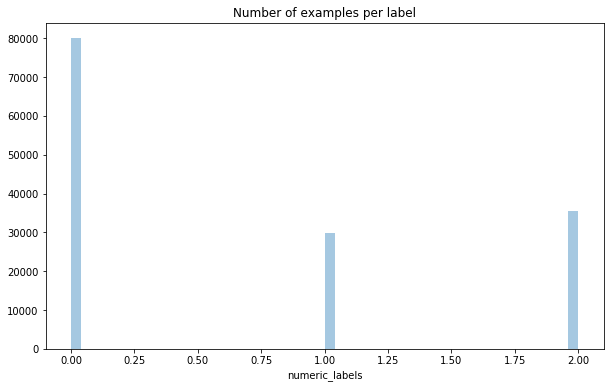

In [18]:
plt.figure(figsize=(10,6))
plt.title('Number of examples per label')
dictionary_associating_values_to_numbers = {name:number for number,name in enumerate(possible_labels)}
train_df['numeric_labels'] = train_df['label'].apply(set_value, args =(dictionary_associating_values_to_numbers, ))
sns.distplot(train_df['numeric_labels'],kde = False,norm_hist=False)
plt.show()

### Data Preparation

In [19]:
def get_all_wiki(path='wiki-pages/wiki-pages'):
    data = []
    for filename in tqdm_notebook(Path(path).rglob('*.jsonl'), total=109):
        data.extend(load_dataset_json(filename))
    data_result = {d['id']:d for d in data}
    return data_result

In [55]:
def match_with_wiki(samples_claim, samples_evidence):
    docs = list()
    count_error = 0
    for c in tqdm_notebook(samples_claim):
        if c['verifiable'] != 'VERIFIABLE':
            continue
        text_evidence = list()
        for e in c['evidence'][0]:
            id_e = e[2]
            if id_e in samples_evidence.keys():
                partial_text = samples_evidence[id_e]['lines'].split('\n')[e[-1]]
                text = '\t'.join(partial_text.split('\t')[1:])
                text = text.replace('\t',' ')
                text_evidence.append(text)
            else:
                count_error += 1
        docs.append((c['claim'], '\n'.join(text_evidence), c['label']))
    print('number of errors')
    print(count_error)
    return docs

In [63]:
train_path = './data/fever-data/train.jsonl'
train_data = load_dataset_json(path=train_path)
dev_path = './data/fever-data/dev.jsonl'
dev_data = load_dataset_json(path=dev_path)
test_path = './data/fever-data/test.jsonl'
test_data = load_dataset_json(path=test_path)

for sample in train_data[:2]:
    print(sample)

{'id': 75397, 'verifiable': 'VERIFIABLE', 'label': 'SUPPORTS', 'claim': 'Nikolaj Coster-Waldau worked with the Fox Broadcasting Company.', 'evidence': [[[92206, 104971, 'Nikolaj_Coster-Waldau', 7], [92206, 104971, 'Fox_Broadcasting_Company', 0]]]}
{'id': 150448, 'verifiable': 'VERIFIABLE', 'label': 'SUPPORTS', 'claim': 'Roman Atwood is a content creator.', 'evidence': [[[174271, 187498, 'Roman_Atwood', 1]], [[174271, 187499, 'Roman_Atwood', 3]]]}


In [20]:
data_wiki = get_all_wiki()

In [21]:
list(data_wiki.keys())[0]

'Beauly_railway_station'

In [27]:
data_wiki['Beauly_railway_station']

{'id': 'Beauly_railway_station',
 'text': 'Beauly railway station serves the village of Beauly in the Highland council area of Scotland . It is the first stop after leaving Inverness station , heading north on the Kyle of Lochalsh Line and the Far North Line . ',
 'lines': '0\tBeauly railway station serves the village of Beauly in the Highland council area of Scotland .\tBeauly\tBeauly\tHighland\tHighland (council area)\tcouncil area\tCouncil areas of Scotland\tScotland\tScotland\n1\tIt is the first stop after leaving Inverness station , heading north on the Kyle of Lochalsh Line and the Far North Line .\tInverness station\tInverness railway station\tKyle of Lochalsh Line\tKyle of Lochalsh Line\tFar North Line\tFar North Line\n2\t'}

In [59]:
train_final_dataset = match_with_wiki(train_data, data_wiki)


number of errors
975


In [66]:
dev_final_dataset = match_with_wiki(dev_data, data_wiki)


number of errors
72


In [65]:
test_final_dataset = match_with_wiki(test_data, data_wiki)


number of errors
65


In [67]:
test_final_dataset[0]

('Ukrainian Soviet Socialist Republic was a founding participant of the UN.',
 'The Ukrainian SSR was a founding member of the United Nations , although it was legally represented by the All-Union state in its affairs with countries outside of the Soviet Union . Soviet Union Soviet Union Ukrainian Ukrainian language Soviet Republics of the Soviet Union United Nations United Nations founding member Member states of the United Nations affairs with countries outside of the Soviet Union Foreign relations of the Soviet Union',
 'SUPPORTS')

In [68]:
df_train = pd.DataFrame(train_final_dataset, columns=['claim','evidence','label'])

In [70]:
df_dev = pd.DataFrame(dev_final_dataset, columns=['claim','evidence','label'])

In [71]:
df_test = pd.DataFrame(test_final_dataset, columns=['claim','evidence','label'])

In [72]:
df_train.to_pickle('./preprocessed_data/fever_train.pkl')

In [73]:
df_dev.to_pickle('./preprocessed_data/fever_dev.pkl')

In [74]:
df_test.to_pickle('./preprocessed_data/fever_test.pkl')